# Setting

In [1]:
from pf_utils import BacktestManager, DataManager, StaticPortfolio, MomentumPortfolio

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
metrics2 = [
    'cagr', 'monthly_vol', 'monthly_sharpe',
    'max_drawdown', 'avg_drawdown','avg_drawdown_days', 
]

path_data = 'data'
path_tran = 'transaction'

# Universe

In [3]:
file_k200 = 'kospi200_prices_240710.csv'
file_etf = 'etfs_all_240710.csv'
download = False

## KOSPI200

In [4]:
k200 = DataManager(
    file = file_k200,
    universe = 'KOSPI200',
    path = path_data
)
k200.upload()

200 assets from 2021-01-04 to 2024-07-10 uploaded.
df_prices updated


In [5]:
kw = dict(
    n_years=3, 
    close_today=True,
    #tickers=k200.df_prices.columns
)
k200.download(**kw) if download else None

In [6]:
df_k200 = k200.df_prices
assetnames_k200 = k200.get_names()

## ETF

In [7]:
etf = DataManager(
    file = file_etf,
    universe = 'ETF',
    path = path_data
)
etf.upload()

870 assets from 2021-01-04 to 2024-07-10 uploaded.
df_prices updated


In [8]:
kw = dict(
    n_years=3, 
    close_today=True,
    #tickers=etf.df_prices.columns
)
etf.download(**kw) if download else None

In [9]:
choice = ['069500', '273130', '148070', '379800', '411060', '284430']
df_etf = etf.df_prices[choice]
assetnames_etf = etf.get_names(tickers=choice)
assetnames_etf

0) 069500: KODEX 200
1) 273130: KODEX 종합채권(AA-이상)액티브
2) 148070: KOSEF 국고채10년
3) 379800: KODEX 미국S&P500TR
4) 411060: ACE KRX금현물
5) 284430: KODEX 200미국채혼합

# Backtest

## KOSPI 200

In [10]:
kwargs_bm = dict(
    initial_capital = 10000000,
    commissions = 0,
    align_axis = 1, 
    days_in_year = 246,
    asset_names = assetnames_k200
)
bm = BacktestManager(df_k200, **kwargs_bm)

15 assets removed for shorter periods (7.5%)
running self.util_check_days_in_year to check days in a year


In [11]:
lags = dict(lookback=12, lag=5)

In [12]:
bm.benchmark_ticker(**lags)

Benchmark is KODEX200
RunOnce selected


In [13]:
select = 'Momentum'
kwargs_build = dict(
    name=select, select =select,
    freq='M', weigh = 'ERC',
    n_assets=5, **lags
)
bm.build(**kwargs_build)

In [14]:
select = 'K-ratio'
kwargs_build.update(dict(
    name=select, select =select
))
bm.build(**kwargs_build)

Backtesting 3 strategies: KODEX200, Momentum, K-ratio


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:59<00:00, 19.73s/it]

Returning stats


,KODEX200,Momentum,K-ratio
start,2021-01-03,2021-01-03,2021-01-03
end,2024-07-10,2024-07-10,2024-07-10
cagr,0.020773,0.728994,0.308676
monthly_vol,0.174975,0.467373,0.253572
monthly_sharpe,0.204963,1.399333,1.192595
max_drawdown,-0.278222,-0.262851,-0.211644
avg_drawdown,-0.061003,-0.059227,-0.030276
avg_drawdown_days,180.0,17.488372,18.261905


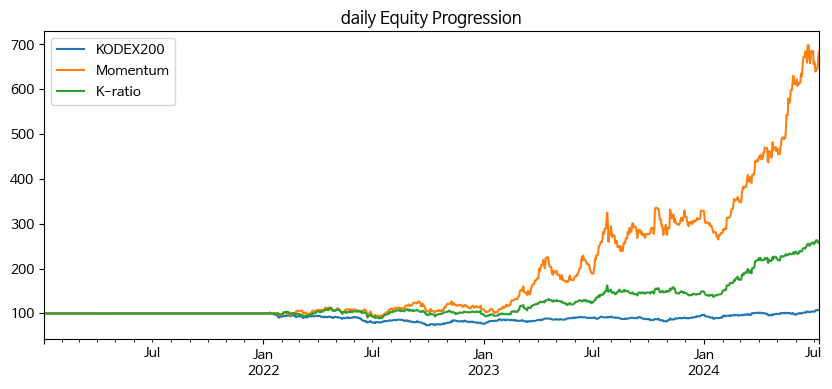

In [15]:
bm.run(figsize=(10,4), metrics=metrics2)

## ETF

In [16]:
kwargs_bm = dict(
    initial_capital = 10000000,
    commissions = 0,
    align_axis = 0, 
    days_in_year = 245,
    asset_names = assetnames_etf
)
bm = BacktestManager(df_etf, **kwargs_bm)

period reset: 2021-12-15 ~ 2024-07-10
running self.util_check_days_in_year to check days in a year


In [17]:
lags = dict(lookback=12, lag=0)

In [18]:
bm.benchmark_ticker(**lags)

Benchmark is KODEX200
RunOnce selected


### Weights

In [19]:
bm.build(
    name = 'COMB1: Eqaully',
    freq = 'Y', select = 'all', weigh = 'equally',
    **lags # added to start backtest on same date with momentum
)

In [20]:
bm.build(
    name = 'COMB2: ERC',
    freq = 'Y', select = 'all', weigh = 'ERC', 
    **lags
)

In [21]:
bm.build(    
    name = 'COMB3: InvVol',
    freq = 'Y', select = 'all', weigh = 'InvVol', 
    **lags
)

Backtesting 4 strategies: KODEX200, COMB1: Eqaully, COMB2: ERC, COMB3: InvVol


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.48it/s]


Returning stats


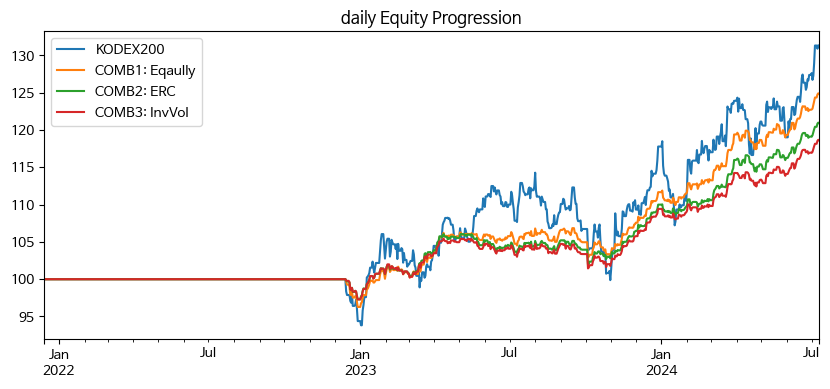

In [22]:
_ = bm.run(figsize=(10,4))

In [23]:
bm.get_stats(sort_by='monthly_sharpe', metrics=metrics2)

,COMB1: Eqaully,COMB2: ERC,COMB3: InvVol,KODEX200
start,2021-12-14,2021-12-14,2021-12-14,2021-12-14
end,2024-07-10,2024-07-10,2024-07-10,2024-07-10
cagr,0.090121,0.076648,0.068648,0.111805
monthly_vol,0.066052,0.05665,0.055714,0.141305
monthly_sharpe,1.336255,1.328341,1.215825,0.816758
max_drawdown,-0.037245,-0.038813,-0.038013,-0.126072
avg_drawdown,-0.00824,-0.007614,-0.00727,-0.02702
avg_drawdown_days,13.558824,17.615385,18.48,20.75


### Freq

In [24]:
kwargs_build = dict(
    select = 'all', **lags,
    weigh = 'ERC', 
    #weigh = 'Equally'
)

kwa_list = [{'name':f'freq {x}', 'freq':x} for x in ['M', 'Q', 'Y']]

bm.build_batch(*kwa_list, **kwargs_build)

In [25]:
bm.portfolios

0) KODEX200
1) COMB1: Eqaully
2) COMB2: ERC
3) COMB3: InvVol
4) freq M
5) freq Q
6) freq Y

In [26]:
pf_list = [4,5,6]
_ = bm.run(pf_list, plot=False)
bm.get_stats(sort_by='monthly_sharpe', metrics=metrics2)

Backtesting 3 strategies: freq M, freq Q, freq Y


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.92it/s]

Returning stats


,freq Q,freq M,freq Y
start,2021-12-14,2021-12-14,2021-12-14
end,2024-07-10,2024-07-10,2024-07-10
cagr,0.079483,0.080227,0.076648
monthly_vol,0.057267,0.05818,0.05665
monthly_sharpe,1.360582,1.351968,1.328341
max_drawdown,-0.037223,-0.037739,-0.038813
avg_drawdown,-0.006954,-0.00693,-0.007614
avg_drawdown_days,15.655172,15.655172,17.615385


In [27]:
pf_list = [1,2,3,5]
_ = bm.run(pf_list, plot=False)
bm.get_stats(sort_by='monthly_sharpe')

Backtesting 4 strategies: COMB1: Eqaully, COMB2: ERC, COMB3: InvVol, freq Q


100%|██████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 72315.59it/s]

Returning stats


,freq Q,COMB1: Eqaully,COMB2: ERC,COMB3: InvVol
start,2021-12-14,2021-12-14,2021-12-14,2021-12-14
end,2024-07-10,2024-07-10,2024-07-10,2024-07-10
total_return,0.217285,0.248365,0.209085,0.186123
cagr,0.079483,0.090121,0.076648,0.068648
calmar,2.135333,2.419682,1.974792,1.805908
max_drawdown,-0.037223,-0.037245,-0.038813,-0.038013
avg_drawdown,-0.006954,-0.00824,-0.007614,-0.00727
avg_drawdown_days,15.655172,13.558824,17.615385,18.48
daily_vol,0.040655,0.046131,0.040403,0.038937
daily_sharpe,1.94902,1.94082,1.894199,1.767652


In [28]:
df = bm.get_security_weights(2).rename_axis(None)
df.columns = [f'{bm.asset_names[x]} ({x})' for x in df.columns]
df.T

COMB3: InvVol: weights at transactions returned


,2022-12-14,2024-03-29
KODEX 200 (069500),0.078634,0.082047
KODEX 종합채권(AA-이상)액티브 (273130),0.345814,0.288400
KOSEF 국고채10년 (148070),0.170546,0.185306
KODEX 미국S&P500TR (379800),0.076890,0.127190
ACE KRX금현물 (411060),0.116309,0.112183
KODEX 200미국채혼합 (284430),0.206625,0.190214


# Transaction

## KOSPI200

In [14]:
kwargs = dict(
    file='pf_k200_momentum.csv',
    method_select='Simple', method_weigh='ERC', lookback=12, lag=5,
    path=path_tran,
    days_in_year=246,
    asset_names=assetnames_k200,
)

pf_k200 = MomentumPortfolio(df_k200, **kwargs)

15 assets removed for shorter periods (7.5%)
running self.util_check_days_in_year to check days in a year
Transaction record to 2024-02-29 loaded.


In [15]:
kwargs = dict(
    #date = '2024-01-01',
    #date = '2024-03-01',
    date = None,
    save = True
)
pf_k200.transaction_pipeline(**kwargs)

5 assets selected by Total return from 2023-07-05 to 2024-07-05
Weights of assets determined by ERC.
Net profit: 7,151,800
All transactions saved to pf_k200_momentum_240710.csv


name   price  transaction  net weights
date       asset                                                
2023-12-28 001570           금양  109200           14   14    0.16
           002710        TCC스틸   58800           31   31    0.19
           005070       코스모신소재  147300           15   15    0.22
           022100        포스코DX   74200           22   22    0.17
           042700        한미반도체   61700           43   43    0.27
2024-02-29 001570           금양   96500          -14    0    0.00
           002710        TCC스틸   67700           -9   22    0.15
           005070       코스모신소재  177100          -15    0    0.00
           006110        삼아알미늄   98900           17   17    0.17
           022100        포스코DX   54100            5   27    0.15
           042700        한미반도체   84800          -18   25    0.21
           267260     HD현대일렉트릭  124400           25   25    0.32
2024-07-10 000150           두산  233500            8    8    0.20
           001570           금양   82500            0    0    0.00
           002710        TCC스틸   49800          -22    0    0.00
           003230         삼양식품  619000            3    3    0.20
           005070       코스모신소재  148300            0    0    0.00
           006110        삼아알미늄   71000          -17    0    0.00
           010120  LS ELECTRIC  224500            8    8    0.20
           022100        포스코DX   37200          -27    0    0.00
           042700        한미반도체  162400          -13   12    0.21
           267260     HD현대일렉트릭  342000          -20    5    0.19

## ETF

In [12]:
kwargs = dict(
    file='pf_etf_static_240710.csv',
    method_weigh='ERC', lookback=12, lag=5,
    path=path_tran,
    days_in_year=245,
    asset_names=assetnames_etf,
)

pf_etf = StaticPortfolio(df_etf, **kwargs)

period reset: 2021-12-15 ~ 2024-07-10
running self.util_check_days_in_year to check days in a year
Transaction record to 2024-07-10 loaded.


In [13]:
pf_etf.transaction_pipeline(save=False)

6 assets from 2023-07-05 to 2024-07-05 prepared for weight analysis
Weights of assets determined by ERC.
ERROR: check the date as no new transaction
Set save=True to save transaction record


price  transaction  net  weights
date       asset                                    
2024-07-10 069500   39735           21   21     0.08
           148070  114330           16   16     0.18
           273130  112380           24   24     0.27
           284430   13490          118  118     0.16
           379800   17560           88   88     0.16
           411060   15005           93   93     0.14